## Example notebook.

This notebook only uses a tiny fraction of the entire dataset to illustrate the following points:

    1) Opening the data csv #And taking a slice of it.

#DataFrameRedis example:

    2) Writing the data to Redis
    3) Getting the data from Redis

#TableTimeSeries example:

    4) Converting the data to Time Series

#(NEW)CalcTemporalFeatures

    5) Calculating temporal features for TRAIN data

#(Optional?) Join temporal & Static data

    6) Joining the temporal feature data with each other to get a labeled train dataset

#(TODO) Train model 

    7) Train a classifier model & store it

#(TODO)

    8) Identify active users

#(TODO)

    9)  Generate temporal features back in time for ONLY the active users
    9.1) Make predictions
    9.2) Store predictions with timestamp

#TableTimeSeries example

    10) Generate Time series of the relevant features of the customers
    #TODO:
        #1) Handle multiple dates
        #2) Join dataframes on shared date
        #3) Resample to Monthly / Quarterly
        #4) Make stationairy
        #5) Fit model


    11) Make multivariate time series forecast 

    12) Optimize


In [12]:
import os
import pandas as pd



**1) Opening the data csv #And taking a slice of it.**

In [13]:
import os
import pandas as pd

p = '/mnt/datasets/datasets/_kaggle churn data'
folder_name = 'churn'
fns = [i[:-4] for i in os.listdir(p) if '.7z' not in i]
fns

['members', 'train', 'user_logs', 'transactions']

In [14]:
dfs = pd.read_csv(os.path.join(p, 'user_logs.csv'), chunksize = 10**6)
for df in dfs:
    users = df
    break
members = pd.read_csv(os.path.join(p, 'members.csv'))
transactions = pd.read_csv(os.path.join(p, 'transactions.csv'))
train = pd.read_csv(os.path.join(p, 'train.csv'))


In [3]:
#Slice the data
ids = users.msno.unique()[:5000]
log_slice = users.loc[users.msno.isin(ids)]
member_slice = members.loc[members.msno.isin(ids)]
transactions_slice = transactions.loc[transactions.msno.isin(ids)]
train_slice = train.loc[train.msno.isin(ids)]


KeyboardInterrupt: 

**2) Writing to Redis**

In [6]:
from timelord.src.redis_dataframe import DataFrameRedis

DFR = DataFrameRedis()
DFR.set_df('churn_log_slice' , log_slice)
DFR.set_df('churn_member_slice' , member_slice)
DFR.set_df('churn_transactions_slice' , transactions_slice)
DFR.set_df('churn_train_slice' , train_slice)


ModuleNotFoundError: No module named 'timelord.src'

In [2]:
from timelord.redis_dataframe import DataFrameRedis
from timelord.table_timeseries import TableTimeSeries

**3) Getting data from Redis**

In [15]:
DFR = DataFrameRedis()
log_slice = DFR.get_df('churn_log_slice')
member_slice = DFR.get_df('churn_member_slice')
transactions_slice = DFR.get_df('churn_transactions_slice')
train_slice = DFR.get_df('churn_train_slice')

ids = log_slice.msno.unique()[:5000]

DataframeRedis.fetch_df churn_log_slice 0.0018405914306640625
unpack dfs: 0.001859426498413086
DataframeRedis.fetch_df churn_member_slice 0.0002231597900390625
unpack dfs: 0.0006291866302490234
DataframeRedis.fetch_df churn_transactions_slice 0.00046634674072265625
unpack dfs: 0.0011010169982910156
DataframeRedis.fetch_df churn_train_slice 0.00022220611572265625
unpack dfs: 0.0006172657012939453


In [4]:
log_slice.head(2)

msno      date  num_25  \
890105  8bY8018HGXHm8s9X3I1CO7mVMthWHUXuY//6LIbjD9Y=  20150130       1   
890106  8bY8018HGXHm8s9X3I1CO7mVMthWHUXuY//6LIbjD9Y=  20150321      10   

        num_50  num_75  num_985  num_100  num_unq  total_secs  
890105       0       1        0      171      149    43222.77  
890106       3       0        1        8       22     2623.85

In [5]:
member_slice.head(2)

msno  city  bd  gender  \
4999522  bXLmqxLaK9PK+OAgN5dzcy1Go1S4AxJtN4TtA4mhzqc=    13  31    male   
5054940  oLEq6WGZPdiIWbD9HwepqNuTeSO7nbd1yhge+GaFlOg=    22  28  female   

         registered_via  registration_init_time  expiration_date  
4999522               3                20120121         20171031  
5054940               3                20120925         20171008

In [6]:
transactions_slice.head(2)

msno  payment_method_id  \
21439253  g0zN+sTOqnrH2w5+FiHz1PCAryOHgt2OcTZRLl3lRbI=                 41   
21445142  X+nlaNf3HPxgDgYKMW9Qg5ynMYLCJhW3B8kxCPe1A3M=                 37   

          payment_plan_days  plan_list_price  actual_amount_paid  \
21439253                 30               99                  99   
21445142                 30              149                 149   

          is_auto_renew  transaction_date  membership_expire_date  is_cancel  
21439253              1          20161123                20161225          0  
21445142              1          20160309                20160410          0

In [7]:
train_slice.head(2)

msno  is_churn
514346  Pph3DpCjk+nwFicH/cQejrVgOsxXzUqlh5kz1fKGi6k=         0
529105  tVPbENwb5LtEb5G69P+GcQjt6OTU0nydIY4Rqr839aE=         0

**4) Converting the data to Time Series**

The date column is (in every table that is used in this example) in a numerical YYYYMMDD format. For this I've added a simple function akin to pandas.to_datetime but with a tiny amount of error catching.

For now I only focus on the datasets with multiple timestamps per member, these can become a nice time series. Same for the members dataset but that is not relevant now. We're focusing on getting data ready for the classifier.

In [8]:
%load_ext autoreload
%autoreload 
from timelord.util import Util

def get_new_dates(df, date_col):
    TTS = TableTimeSeries()
    df[date_col] = df[date_col].apply(Util.break_date)
    df = TTS.recast_date_column(df, date_col)
    return df 
 


log_date_column = 'date'
new_log_slice = get_new_dates(log_slice.copy(), log_date_column)

transactions_date_column = 'transaction_date'
new_transactions_slice = get_new_dates(transactions_slice.copy(), transactions_date_column)


In [9]:
TTS = TableTimeSeries()
test_slice = new_log_slice.loc[new_log_slice.msno == new_log_slice.msno.unique()[0]]
log_time_series = TTS.build_df_per_id(df = new_log_slice, 
                                      date_column  = log_date_column, 
                                      min_resolution = 'day', 
                                      id_column = 'msno', 
                                      use_multiprocessing = True)

trans_time_series = TTS.build_df_per_id(df = new_transactions_slice, 
                                      date_column  = transactions_date_column, 
                                      min_resolution = 'day', 
                                      id_column = 'msno', 
                                      use_multiprocessing = True)
trans_time_series.head(2)

Done with grouping 0.0003294944763183594
Done with MultiProcessing 0.582578182220459
Done 0.6032094955444336
Done with grouping 0.00040793418884277344
Done with MultiProcessing 0.46691155433654785
Done 0.48711299896240234


payment_method_id  payment_plan_days  plan_list_price  \
join_column_name                                                          
2015-01-14                     41.0               30.0            149.0   
2015-01-15                      NaN                NaN              NaN   

                  actual_amount_paid  is_auto_renew  membership_expire_date  \
join_column_name                                                              
2015-01-14                     149.0            1.0              20150214.0   
2015-01-15                       NaN            NaN                     NaN   

                  is_cancel                                          msno  
join_column_name                                                           
2015-01-14              0.0  +KuJ5syx35L9N3qtwTDXSN6Ku/nD84cEPpWbVVdlbFc=  
2015-01-15              NaN  +KuJ5syx35L9N3qtwTDXSN6Ku/nD84cEPpWbVVdlbFc=

In [66]:
test_slice.head()

msno       date  num_25  \
890105  8bY8018HGXHm8s9X3I1CO7mVMthWHUXuY//6LIbjD9Y= 2015-01-30       1   
890106  8bY8018HGXHm8s9X3I1CO7mVMthWHUXuY//6LIbjD9Y= 2015-03-21      10   
890107  8bY8018HGXHm8s9X3I1CO7mVMthWHUXuY//6LIbjD9Y= 2015-05-10       1   
890108  8bY8018HGXHm8s9X3I1CO7mVMthWHUXuY//6LIbjD9Y= 2015-06-29       5   
890109  8bY8018HGXHm8s9X3I1CO7mVMthWHUXuY//6LIbjD9Y= 2015-08-18      13   

        num_50  num_75  num_985  num_100  num_unq  total_secs  
890105       0       1        0      171      149   43222.770  
890106       3       0        1        8       22    2623.850  
890107       0       1        0      149      142   38241.892  
890108       0       0        1      122      119   31656.623  
890109       1       0        1      138      140   35743.930

In [71]:
test_slice = new_log_slice.loc[new_log_slice.msno == new_log_slice.msno.unique()[0]]

TTS.build_df(test_slice, 'date', min_resolution= 'month')

num_25  num_50  num_75  num_985  num_100  num_unq  \
join_column_name                                                      
2015-01-01           2.0     0.0     2.0      0.0    342.0    298.0   
2015-02-01           NaN     NaN     NaN      NaN      NaN      NaN   
2015-03-01         310.0    93.0     0.0     31.0    248.0    682.0   
2015-04-01           NaN     NaN     NaN      NaN      NaN      NaN   
2015-05-01          31.0     0.0    31.0      0.0   4619.0   4402.0   
2015-06-01         150.0     0.0     0.0     30.0   3660.0   3570.0   
2015-07-01           NaN     NaN     NaN      NaN      NaN      NaN   
2015-08-01         403.0    31.0     0.0     31.0   4278.0   4340.0   
2015-09-01           NaN     NaN     NaN      NaN      NaN      NaN   
2015-10-01         217.0    93.0     0.0      0.0   4154.0   4185.0   
2015-11-01         450.0    60.0    90.0      0.0   5430.0   5340.0   
2015-12-01           NaN     NaN     NaN      NaN      NaN      NaN   
2016-01-01          93.0     0.0     0.0      0.0   4340.0   4371.0   
2016-02-01           NaN     NaN     NaN      NaN      NaN      NaN   
2016-03-01         155.0    31.0    31.0      0.0   3379.0   3317.0   
2016-04-01         180.0    30.0    30.0     60.0   4050.0   4200.0   
2016-05-01           NaN     NaN     NaN      NaN      NaN      NaN   
2016-06-01          30.0     0.0    30.0     30.0    180.0    210.0   
2016-07-01           NaN     NaN     NaN      NaN      NaN      NaN   
2016-08-01         155.0    93.0    62.0     62.0   3813.0   3813.0   
2016-09-01          60.0     0.0    30.0     30.0    600.0    720.0   
2016-10-01           NaN     NaN     NaN      NaN      NaN      NaN   
2016-11-01         240.0    60.0    60.0     30.0   5130.0   4890.0   
2016-12-01           NaN     NaN     NaN      NaN      NaN      NaN   
2017-01-01         527.0    62.0    31.0     31.0   4340.0   4712.0   
2017-02-01         270.0    54.0     0.0     81.0   4131.0   3969.0   

                   total_secs  
join_column_name               
2015-01-01          86445.540  
2015-02-01                NaN  
2015-03-01          81339.350  
2015-04-01                NaN  
2015-05-01        1185498.652  
2015-06-01         949698.690  
2015-07-01                NaN  
2015-08-01        1108061.830  
2015-09-01                NaN  
2015-10-01        1063723.894  
2015-11-01        1405490.160  
2015-12-01                NaN  
2016-01-01        1099907.962  
2016-02-01                NaN  
2016-03-01         870275.462  
2016-04-01        1042737.330  
2016-05-01                NaN  
2016-06-01          54154.170  
2016-07-01                NaN  
2016-08-01        1001165.274  
2016-09-01         160356.180  
2016-10-01                NaN  
2016-11-01        1347842.970  
2016-12-01                NaN  
2017-01-01        1137698.109  
2017-02-01        1072418.373

In [75]:
new_log_slice.date.dt.to_period('m')

890105   2015-01
890106   2015-03
890107   2015-05
890108   2015-06
890109   2015-08
890110   2015-10
890111   2015-11
890112   2016-01
890113   2016-03
890114   2016-04
890115   2016-06
890116   2016-08
890117   2016-09
890118   2016-11
890119   2017-01
890120   2017-02
902829   2015-01
902830   2015-03
902831   2015-04
902832   2015-06
902833   2015-07
902834   2015-09
902835   2015-11
902836   2015-12
902837   2016-02
902838   2016-04
902839   2016-06
902840   2016-07
902841   2016-09
902842   2016-11
           ...  
968075   2015-04
968076   2015-06
968077   2015-08
968078   2015-10
968079   2015-11
968080   2016-01
968081   2016-02
968082   2016-04
968083   2016-06
968084   2016-07
968085   2016-09
968086   2016-11
968087   2016-12
968088   2017-02
968673   2015-01
968674   2015-03
968675   2015-04
968676   2015-06
968677   2015-08
968678   2015-09
968679   2015-11
968680   2016-01
968681   2016-02
968682   2016-04
968683   2016-06
968684   2016-07
968685   2016-09
968686   2016-

In [78]:
pd.date_range(start = new_log_slice.date.iloc[0], end = new_log_slice.date.iloc[-1], freq = 'M')

DatetimeIndex(['2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31', '2015-11-30', '2015-12-31',
               '2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
               '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31',
               '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31',
               '2017-01-31'],
              dtype='datetime64[ns]', freq='M')

In [10]:
log_time_series.head(2)


num_25  num_50  num_75  num_985  num_100  num_unq  \
join_column_name                                                      
2015-01-27           5.0     1.0     1.0      0.0     36.0     42.0   
2015-01-28           NaN     NaN     NaN      NaN      NaN      NaN   

                  total_secs                                          msno  
join_column_name                                                            
2015-01-27          9556.241  +KuJ5syx35L9N3qtwTDXSN6Ku/nD84cEPpWbVVdlbFc=  
2015-01-28               NaN  +KuJ5syx35L9N3qtwTDXSN6Ku/nD84cEPpWbVVdlbFc=

The DataFrame has been transformed to a complete Time series per ID. For illustration I have plotted some of the time series over time.

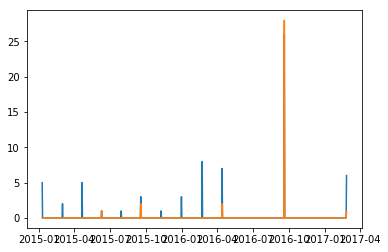

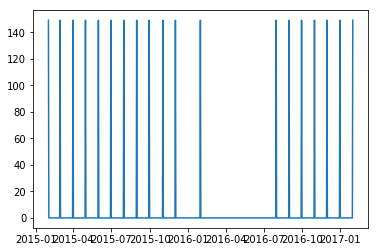

In [19]:
#########################
##### Only for illustration purposes
#########################

import matplotlib.pyplot as plt
USER_ID = ids[1]

slic = log_time_series.loc[log_time_series.msno == USER_ID] #Slice the data so when only get one time series
#slic.index = pd.DatetimeIndex(slic['join_column_name'])
plt.plot(slic['num_25'].fillna(0.0))
plt.plot(slic['num_50'].fillna(0.0))
plt.show()

slic2 = trans_time_series.loc[trans_time_series.msno == USER_ID] #Slice the data so when only get one time series
#slic2.index = pd.DatetimeIndex(slic2['join_column_name'])
plt.plot(slic2['actual_amount_paid'].fillna(0.0))
plt.show()

**5) Calculating temporal features for TRAIN data**

Based on the time series it is relatively easy to calculate a set of temporal features. 

*One must note that the step to time series isn't necessary to calculate the temporal features*. These can also be retrieved directly from the original data. Nevertheless the time series are also used in a later stage so better to compute these and use them directly.



In [24]:
def get_features(ndf, column_operations, day):
    new_df = pd.DataFrame() #Error catching
    for col, operations in column_operations.items():
        for operation in operations:
            val = getattr(ndf[col].fillna(0), operation)()
            new_df['{}_{}_{}'.format(col, operation, day)] = [val]
    return new_df


def calc_temp_features(df, date_column, date, days, column_operations, USER_ID):
    df_list = []
    for day in days[::-1]:
        df = df.loc[(df.index >= pd.to_datetime(date) - pd.Timedelta(days = day)) &
                       (df.index < pd.to_datetime(date))]    
        feature_df = get_features(df, column_operations, day)
        df_list.append(feature_df)
        
    df = pd.concat(df_list, axis = 1)
    df['new_date_column'] = [date]
    df['msno'] = [USER_ID]
    return df



In [25]:
days = [30, 60, 120, 180, 360, 720, 1080]

transaction_column_operations = {
    'payment_method_id': ['nunique'], #Also add as static variable?
    'payment_plan_days': ['mean'],
    'plan_list_price':['sum', 'mean', 'nunique'],
    'actual_amount_paid':['sum', 'mean', 'nunique'],
    'is_auto_renew': ['nunique', 'sum'],
    'is_cancel': ['nunique', 'sum'],
}
    
user_log_column_operations = {
    'num_25': ['sum', 'mean', 'nunique', 'max', 'std'],
    'num_75': ['sum', 'mean', 'nunique', 'max', 'std'],
    'num_100': ['sum', 'mean', 'nunique', 'max', 'std'],
    'num_unq': ['sum', 'mean', 'nunique', 'max', 'std'],
    'total_secs': ['mean', 'max', 'std'],
}



temp_feature_transaction_list = []
temp_feature_user_log_list = []

for USER_ID in ids:
    #The date that is used to compute the temporal features is of the utmost importance. 
    #This date should reflect the date when the to be predicted variable occured.
    
    #Maybe the 'transaction_date' is not the most optimal column to use in this case.
    #Needs further refinement.
    transcation_date = trans_time_series.index.values[-1]
    
    
    transaction_df_slice = trans_time_series.loc[trans_time_series.msno == USER_ID] #Slice per user
    transaction_temp_features = calc_temp_features(
                                        transaction_df_slice, 
                                        transactions_date_column, 
                                        transcation_date,
                                        days,
                                        transaction_column_operations,
                                        USER_ID)

    user_log_slice = log_time_series.loc[log_time_series.msno == USER_ID] #Slice per user
    user_log_temp_features = calc_temp_features(
                                            user_log_slice, 
                                            log_date_column, 
                                            transcation_date,
                                            days,
                                            user_log_column_operations,
                                            USER_ID)


    temp_feature_transaction_list.append(transaction_temp_features)
    temp_feature_user_log_list.append(user_log_temp_features)
 


transaction_temp_features = pd.concat(temp_feature_transaction_list)
user_log_temp_features = pd.concat(temp_feature_user_log_list)
    
transaction_temp_features.head()

payment_method_id_nunique_1080  payment_plan_days_mean_1080  \
0                               2                     0.947195   
0                               2                     0.678756   
0                               2                     0.678756   
0                               2                     0.576923   
0                               2                     0.678756   

   plan_list_price_sum_1080  plan_list_price_mean_1080  \
0                    2831.0                   4.671617   
0                    1937.0                   3.345423   
0                    1937.0                   3.345423   
0                    1490.0                   2.865385   
0                    1937.0                   3.345423   

   plan_list_price_nunique_1080  actual_amount_paid_sum_1080  \
0                             2                       2980.0   
0                             2                       2086.0   
0                             2                       2086.0   
0                             2                       2384.0   
0                             2                       2086.0   

   actual_amount_paid_mean_1080  actual_amount_paid_nunique_1080  \
0                      4.917492                                2   
0                      3.602763                                2   
0                      3.602763                                2   
0                      4.584615                                2   
0                      3.602763                                2   

   is_auto_renew_nunique_1080  is_auto_renew_sum_1080  \
0                           2                    20.0   
0                           2                    14.0   
0                           2                    14.0   
0                           2                    16.0   
0                           2                    14.0   

                       ...                       plan_list_price_nunique_30  \
0                      ...                                                2   
0                      ...                                                2   
0                      ...                                                2   
0                      ...                                                2   
0                      ...                                                2   

   actual_amount_paid_sum_30  actual_amount_paid_mean_30  \
0                      149.0                    4.966667   
0                      149.0                    4.966667   
0                      149.0                    4.966667   
0                      149.0                    4.966667   
0                      149.0                    4.966667   

   actual_amount_paid_nunique_30  is_auto_renew_nunique_30  \
0                              2                         2   
0                              2                         2   
0                              2                         2   
0                              2                         2   
0                              2                         2   

   is_auto_renew_sum_30  is_cancel_nunique_30  is_cancel_sum_30  \
0                   1.0                     1               0.0   
0                   1.0                     1               0.0   
0                   1.0                     1               0.0   
0                   1.0                     1               0.0   
0                   1.0                     1               0.0   

   new_date_column                                          msno  
0       2016-09-01  8bY8018HGXHm8s9X3I1CO7mVMthWHUXuY//6LIbjD9Y=  
0       2016-09-01  GH9jj8D5PFk/XrWCwmMPYudoLpsNEWDEKWvSFUEKwGw=  
0       2016-09-01  yNIPcdSZa4S67vNIRi18F2bObs4IDClpYP57X+foIvc=  
0       2016-09-01  3P9peYdnaPZQvzrH4RfP/vLmx1ViTJak4FafR3X7j/A=  
0       2016-09-01  Mho4juJsyHi2jx1oSP2ef0m3/IQ2+1f+4lKlvkUsEGc=  

[5 rows x 86 columns]

Above are the temporal features for the user_logs and transactions. These can be used for the classifier to train the model on. While temporal features are a very useful tool the make prediction with, static data is also valuable. 


However, the model isn't able to handle this perfectly on its own. Thus we build the static data in such a manner that it's workable for the model. E.g. by creating dummy data & additional features

**x) Work the Static data into features**

In [26]:
#Get features from the static data
dummy_columns = ['registered_via', 'gender', 'city']
#Get dummy features
dummy_data = pd.get_dummies(member_slice[dummy_columns].fillna(0).astype('str')) #Gender has NaNs
#Get timedelta as feature
member_slice = get_new_dates(member_slice, 'registration_init_time')
member_slice = get_new_dates(member_slice, 'expiration_date')
dummy_data['member_time_days'] = (member_slice['expiration_date'] - member_slice['registration_init_time']).apply(lambda x: x.total_seconds()/ 86400)
dummy_data['msno'] = member_slice['msno']
dummy_data.head()

registered_via_3  registered_via_7  registered_via_9  gender_0  \
4999522                 1                 0                 0         0   
5054940                 1                 0                 0         0   
5075197                 0                 1                 0         0   
4878510                 0                 0                 1         0   
4693821                 0                 1                 0         0   

         gender_female  gender_male  city_1  city_10  city_11  city_12  \
4999522              0            1       0        0        0        0   
5054940              1            0       0        0        0        0   
5075197              0            1       0        0        0        0   
4878510              0            1       0        0        0        0   
4693821              0            1       1        0        0        0   

                             ...                       city_18  city_21  \
4999522                      ...                             0        0   
5054940                      ...                             0        0   
5075197                      ...                             0        0   
4878510                      ...                             0        0   
4693821                      ...                             0        0   

         city_22  city_4  city_5  city_6  city_8  city_9  member_time_days  \
4999522        0       0       0       0       0       0            2110.0   
5054940        1       0       0       0       0       0            1839.0   
5075197        0       0       0       0       0       0            2577.0   
4878510        1       0       0       0       0       0            1473.0   
4693821        0       0       0       0       0       0            2468.0   

                                                 msno  
4999522  bXLmqxLaK9PK+OAgN5dzcy1Go1S4AxJtN4TtA4mhzqc=  
5054940  oLEq6WGZPdiIWbD9HwepqNuTeSO7nbd1yhge+GaFlOg=  
5075197  wx1zmOgI0MqP2D0lzY4mPD+pArQdXGvtrBEIJfONjP4=  
4878510  7TBdn82CP2TWhFQgy/gGuWreOkAXmjoa5JQVEZ9cA3g=  
4693821  Xl6g6MrJV9yOI+x3xT3oNvdBPoA4CYHkyJRK6RHDz3g=  

[5 rows x 23 columns]

Above is the members data worked into a format that he model can handle. Time to join the data and train the model.


**6) Joining the temporal feature data with each other to get a labeled train dataset**


In [27]:
user_log_temp_features = user_log_temp_features.drop('new_date_column', axis =1) #Drop the timestamp column for training
transaction_temp_features = transaction_temp_features.drop('new_date_column', axis =1) #Drop the timestamp column for training

In [28]:
train_df = train_slice.merge(right = dummy_data,
                           on = 'msno',
                           how = 'left')

train_df = train_df.merge(right = user_log_temp_features,
                           on = 'msno',
                           how = 'left')

train_df = train_df.merge(right = transaction_temp_features,
                           on = 'msno',
                           how = 'left')

print(train_df.shape)
train_df.head()

(76, 269)


msno  is_churn  registered_via_3  \
0  Pph3DpCjk+nwFicH/cQejrVgOsxXzUqlh5kz1fKGi6k=         0                 0   
1  tVPbENwb5LtEb5G69P+GcQjt6OTU0nydIY4Rqr839aE=         0                 0   
2  X+nlaNf3HPxgDgYKMW9Qg5ynMYLCJhW3B8kxCPe1A3M=         0                 0   
3  2NKqLbpOU37u8d6ZHdEW0cbIUGJ1mXqSx1NccKOvevY=         0                 0   
4  geIZh6vRhAxAoSW44ccURiXwBSBCKzPyQ0bj8bEouH4=         0                 0   

   registered_via_7  registered_via_9  gender_0  gender_female  gender_male  \
0                 1                 0         0              0            1   
1                 0                 1         0              1            0   
2                 0                 1         0              0            1   
3                 1                 0         0              1            0   
4                 0                 1         0              0            1   

   city_1  city_10        ...         plan_list_price_sum_30  \
0       0        0        ...                            0.0   
1       0        0        ...                          149.0   
2       0        0        ...                          149.0   
3       0        0        ...                          149.0   
4       0        0        ...                          149.0   

   plan_list_price_mean_30  plan_list_price_nunique_30  \
0                 0.000000                           1   
1                 4.966667                           2   
2                 4.966667                           2   
3                 4.966667                           2   
4                 4.966667                           2   

   actual_amount_paid_sum_30  actual_amount_paid_mean_30  \
0                        0.0                    0.000000   
1                      149.0                    4.966667   
2                      149.0                    4.966667   
3                      149.0                    4.966667   
4                      149.0                    4.966667   

   actual_amount_paid_nunique_30  is_auto_renew_nunique_30  \
0                              1                         1   
1                              2                         2   
2                              2                         2   
3                              2                         2   
4                              2                         2   

   is_auto_renew_sum_30  is_cancel_nunique_30  is_cancel_sum_30  
0                   0.0                     1               0.0  
1                   1.0                     1               0.0  
2                   1.0                     1               0.0  
3                   1.0                     1               0.0  
4                   1.0                     1               0.0  

[5 rows x 269 columns]

In [29]:
#Final prep
target_column = 'is_churn'
y = train_df[target_column]
X = train_df.drop(['msno', target_column], axis = 1).fillna(0.0)

In [63]:
import time
import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier

s = time.time()
model = RandomForestClassifier()
model.fit(X, y)
print(model, cross_val_score(model, X, y, cv =2))
print("Completed in {:0.2f} seconds".format(time.time() - s))


#All zeros forecast accuracy:
print(Counter(y), accuracy_score(np.zeros(len(y)), y))

#View the feature importance:
sorted({k: v for k,v in zip(X.columns, model.feature_importances_)}.items(), key = lambda x: x[1], reverse = True)[:10]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) [ 0.94871795  0.97297297]
Completed in 0.04 seconds
Counter({0: 73, 1: 3}) 0.960526315789


[('plan_list_price_mean_720', 0.099648278415401803),
 ('num_100_std_1080', 0.084900900900900925),
 ('actual_amount_paid_mean_1080', 0.073972602739726029),
 ('is_auto_renew_nunique_180', 0.065765765765765732),
 ('plan_list_price_nunique_30', 0.04933333333333334),
 ('actual_amount_paid_mean_720', 0.048648648648648624),
 ('num_25_mean_1080', 0.040976535541752929),
 ('num_25_nunique_1080', 0.036527654540076906),
 ('num_100_max_1080', 0.034234234234234259),
 ('num_25_mean_360', 0.030938662692372786)]

The model has been trained on a sample of the dataset. The Kaggle competition stops here. The ask in the competition was to predict the churn probabilty for a set of customers. We're able to do so now with the trained model and the calculated features.

However, we're gonna continue because we want a time series probability prediction.

**8) Identify active users**


We're only interested in the users that still have a chance to churn, thus the active users are the only ones we're interested in. Because this dataset is obviously historic we're gonna set our current time to *2017-01-01*. Everything beyond that is "Future".

In [31]:
current_date = pd.to_datetime('2017-01-01')

new_trans_slice = get_new_dates(transactions_slice.copy(), 'membership_expire_date')
active_user_ids = new_trans_slice.loc[new_trans_slice.membership_expire_date > current_date].msno.unique()
#A customer is still active when his expire date exceeds the "Current date"

In [32]:
#We also need to get the dataset up to date. So we're gonna cut off all the "future" data and select it only for the
#relevant customers:
active_user_transactions = new_trans_slice.loc[new_trans_slice.msno.isin(ids)]
new_log_slice = get_new_dates(log_slice.copy(), 'date')
active_user_logs = new_log_slice.loc[new_log_slice.msno.isin(active_user_ids)]

    9)  Generate temporal features back in time for ONLY the active users
    9.1) Make predictions
    9.2) Store predictions with timestamp
    
    
**To keep the code simple I will continue from here on with only a SINGLE user. This approach applies for each active user though.**

In [41]:
def get_new_dates(df, date_col):
    TTS = TableTimeSeries()
    df[date_col] = df[date_col].apply(Util.break_date)
    df = TTS.recast_date_column(df, date_col)
    return df 

USER_ID = active_user_ids[0]

trans = active_user_transactions.loc[active_user_transactions.msno == USER_ID]
trans = get_new_dates(trans, 'transaction_date')
user_log = active_user_logs.loc[active_user_logs.msno == USER_ID]
#user_log = get_new_dates(user_log, 'date')

static_data = dummy_data.loc[dummy_data.msno == USER_ID]

/data/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [44]:
def calc_temp_features(df, date_column, date, days, column_operations, USER_ID):
    df_list = []
    for day in days[::-1]:
        df = df.loc[(df[date_column] >= pd.to_datetime(date) - pd.Timedelta(days = day)) &
                       (df[date_column] < pd.to_datetime(date))]    
        feature_df = get_features(df, column_operations, day)
        df_list.append(feature_df)
        
    df = pd.concat(df_list, axis = 1)
    df['new_date_column'] = [date]
    df['msno'] = [USER_ID]
    return df

def calc_eta_time(total_amount, i, start_time): #UNRELATED Cool helper function
    total_amount = len(forecast_date_range)
    total_duration = time.time() - start_time
    duration_per_iteration = total_duration / i
    amount_remaining = total_amount  - i
    time_remaining = amount_remaining * duration_per_iteration
    return time_remaining, time.time() - start_time, total_amount, i

#We keep the EXACT same features as we did with training. Else the classifier goes haywire.

days = [30, 60, 120, 180, 360, 720, 1080]

transaction_column_operations = {
    'payment_method_id': ['nunique'], #Also add as static variable?
    'payment_plan_days': ['mean'],
    'plan_list_price':['sum', 'mean', 'nunique'],
    'actual_amount_paid':['sum', 'mean', 'nunique'],
    'is_auto_renew': ['nunique', 'sum'],
    'is_cancel': ['nunique', 'sum'],
}
    
user_log_column_operations = {
    'num_25': ['sum', 'mean', 'nunique', 'max', 'std'],
    'num_75': ['sum', 'mean', 'nunique', 'max', 'std'],
    'num_100': ['sum', 'mean', 'nunique', 'max', 'std'],
    'num_unq': ['sum', 'mean', 'nunique', 'max', 'std'],
    'total_secs': ['mean', 'max', 'std'],
}

#Because we want multiple forecasts we need to generaste multiple temporal feature datasets.
#This we can do by iterating over a date and calculting from there on. I preferably forecast from T+0 to T-N, or, back in time.

earliest_date = pd.to_datetime('2015-01-01')

forecast_date_range = pd.date_range(start = earliest_date,
                                   end = current_date)


#Iterate over the daterange to populate the forecast_dict

s = time.time() 
forecast_dict = {}
for i, forecast_date in enumerate(forecast_date_range):

    
    if i % 10 == 0 and i > 0:
        print(calc_eta_time(len(forecast_date_range), i, s), forecast_date)
        #Calc features for forecast
    transaction_temp_features = calc_temp_features(
                                        trans, 
                                        'membership_expire_date', #For training we used the transaction date! I think this is ok.
                                        forecast_date,
                                        days,
                                        transaction_column_operations,
                                        USER_ID)

    user_log_slice = log_time_series.loc[log_time_series.msno == USER_ID] #Slice per user
    user_log_temp_features = calc_temp_features(
                                            user_log, 
                                            'date', 
                                            forecast_date,
                                            days,
                                            user_log_column_operations,
                                            USER_ID)


    #Fillnan
    transaction_temp_features = transaction_temp_features.drop(['new_date_column'], axis = 1).fillna(0.0)
    user_log_temp_features = user_log_temp_features.drop(['new_date_column'], axis = 1).fillna(0.0)

    #Join data to test df
    test_df = static_data.merge(right = user_log_temp_features,
                               on = 'msno',
                               how = 'left')

    test_df = test_df.merge(right = transaction_temp_features,
                               on = 'msno',
                               how = 'left')

    test_df = test_df.drop('msno', axis =1)
    prob_forecast = model.predict_proba(test_df)
    forecast_dict[forecast_date] = prob_forecast



(151.9328887462616, 2.104334831237793, 732, 10) 2015-01-11 00:00:00
(152.89135065078736, 4.294701814651489, 732, 20) 2015-01-21 00:00:00
(152.9310191631317, 6.535514831542969, 732, 30) 2015-01-31 00:00:00
(151.8870412349701, 8.779598951339722, 732, 40) 2015-02-10 00:00:00
(151.5053872203827, 11.107434272766113, 732, 50) 2015-02-20 00:00:00
(150.6590476989746, 13.451701879501343, 732, 60) 2015-03-02 00:00:00
(148.73373257773264, 15.72713327407837, 732, 70) 2015-03-12 00:00:00
(146.79178869724274, 18.011263847351074, 732, 80) 2015-03-22 00:00:00
(144.88232622146606, 20.310607433319092, 732, 90) 2015-04-01 00:00:00
(142.72108947753907, 22.582452058792114, 732, 100) 2015-04-11 00:00:00
(140.92837307669902, 24.923025131225586, 732, 110) 2015-04-21 00:00:00
(138.71238849163055, 27.198508501052856, 732, 120) 2015-05-01 00:00:00
(136.5083069067735, 29.478538751602173, 732, 130) 2015-05-11 00:00:00
(134.40910028730121, 31.78593683242798, 732, 140) 2015-05-21 00:00:00
(132.13501727104187, 34.055

Below is the forecast dict as populated by the RandomForecast model. This can be used, along with the other Time Series for the multi-variate forecast model.

In [333]:
forecast_dict

{Timestamp('2015-01-01 00:00:00', freq='D'): array([[ 1.,  0.]]),
 Timestamp('2015-01-02 00:00:00', freq='D'): array([[ 1.,  0.]]),
 Timestamp('2015-01-03 00:00:00', freq='D'): array([[ 1.,  0.]]),
 Timestamp('2015-01-04 00:00:00', freq='D'): array([[ 1.,  0.]]),
 Timestamp('2015-01-05 00:00:00', freq='D'): array([[ 1.,  0.]]),
 Timestamp('2015-01-06 00:00:00', freq='D'): array([[ 1.,  0.]]),
 Timestamp('2015-01-07 00:00:00', freq='D'): array([[ 1.,  0.]]),
 Timestamp('2015-01-08 00:00:00', freq='D'): array([[ 1.,  0.]]),
 Timestamp('2015-01-09 00:00:00', freq='D'): array([[ 1.,  0.]]),
 Timestamp('2015-01-10 00:00:00', freq='D'): array([[ 1.,  0.]]),
 Timestamp('2015-01-11 00:00:00', freq='D'): array([[ 1.,  0.]]),
 Timestamp('2015-01-12 00:00:00', freq='D'): array([[ 1.,  0.]]),
 Timestamp('2015-01-13 00:00:00', freq='D'): array([[ 1.,  0.]]),
 Timestamp('2015-01-14 00:00:00', freq='D'): array([[ 1.,  0.]]),
 Timestamp('2015-01-15 00:00:00', freq='D'): array([[ 1.,  0.]]),
 Timestamp

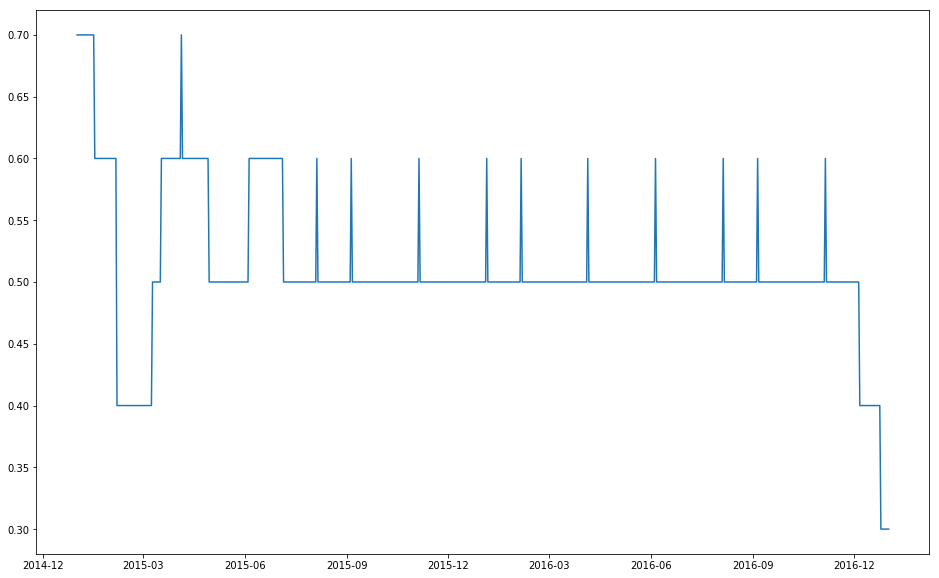

In [45]:
fcdf = pd.DataFrame(sorted(forecast_dict.items(), key = lambda x: x[0]))
fcdf[1] = fcdf[1].apply(lambda x: x[0][0])
fcdf.index = fcdf[0]
fcdf = fcdf.drop(0, axis = 1)
fcdf.index.name = 'Time'
fcdf.columns = ['churn_prob']
plt.figure(figsize = (16, 10))
plt.plot(fcdf)
plt.show()

In [46]:
#Select the time series belonging to our USER_ID and fillnans
user_log_time_series = log_time_series.loc[log_time_series.msno == USER_ID].fillna(0.0)
user_trans_time_series = trans_time_series.loc[trans_time_series.msno == USER_ID].fillna(0.0)

**    10) Generate Time series of the relevant features of the customers**

#TODO:) Make stationairy


 

In [48]:
#Slice only the relevant columns and set the date to the index.
trans_columns = ['payment_method_id', 'actual_amount_paid', 'is_auto_renew','is_cancel']
log_columns = ['num_25', 'num_50', 'num_75', 'num_985','num_100', 'num_unq', 'total_secs']

user_trans_time_series_panel = user_trans_time_series[trans_columns]
user_log_time_series_panel = user_log_time_series[log_columns]

#user_trans_time_series_panel.index = user_trans_time_series['join_column_name']
#user_log_time_series_panel.index = user_log_time_series['join_column_name']


In [57]:
%autoreload

#Correct for multiple dates (if occuring)
TTS = TableTimeSeries()
fixed_user_trans_time_series = TTS.handle_multiple_dates(user_trans_time_series_panel)
fixed_user_log_time_series_panel = TTS.handle_multiple_dates(user_log_time_series_panel)

#Join the multiple dataframes based on their DatetimeIndex
complete_joined_tdf = TTS.join_time_series_dfs_on_index(fixed_user_trans_time_series, 
                                                        fixed_user_log_time_series_panel,
                                                        set_as_index = True)

complete_joined_tdf = complete_joined_tdf.fillna(0.0)

final_dataframe = TTS.join_time_series_dfs_on_index(complete_joined_tdf, 
                                                    fcdf,
                                                    set_as_index = True)


#Cut off front and final date.
sliced_final = final_dataframe.loc[(final_dataframe.index < current_date) &
                                   (final_dataframe.index > complete_joined_tdf.index[0])]

fc_data = sliced_final.resample('M').mean()
fc_data += 1 #The model can't handle 0 values seemingly. Don't forget to subtract this after forecasting!

#Drop constants
fc_data = fc_data.drop('is_cancel', axis =1)

In [58]:
fc_data.head()

payment_method_id  actual_amount_paid  is_auto_renew  \
join_column_name                                                         
2015-01-31                 1.000000            1.000000       1.000000   
2015-02-28                 2.464286            6.321429       1.035714   
2015-03-31                 2.322581            5.806452       1.032258   
2015-04-30                 2.366667            5.966667       1.033333   
2015-05-31                 2.322581            5.806452       1.032258   

                    num_25    num_50    num_75   num_985   num_100   num_unq  \
join_column_name                                                               
2015-01-31        1.192308  1.038462  1.192308  1.038462  2.153846  2.346154   
2015-02-28        1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2015-03-31        1.000000  1.000000  1.000000  1.032258  3.967742  2.258065   
2015-04-30        1.466667  1.033333  1.033333  1.033333  1.766667  2.233333   
2015-05-31        1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

                  total_secs  churn_prob  
join_column_name                          
2015-01-31        352.998077    1.642308  
2015-02-28          1.000000    1.435714  
2015-03-31        763.874258    1.516129  
2015-04-30        194.370367    1.600000  
2015-05-31          1.000000    1.500000

Above is the final panel ready to be fed into the multivariate model. Notice the churn_prob in the right column. That's what we're doing all this for... Now we can fiut the model and make a prediction


**   11) Make multivariate time series forecast **

In [59]:
### Can this data even be made stationairy?
### Optimal lag_order?
### Find model that can work with non-stationary time series

from statsmodels.tsa.api import VAR, DynamicVAR

lag_order = 2
forecast_length = 3
alpha = 0.05

churn_prob_index = -1


model = VAR(fc_data)
results = model.fit(lag_order)

In [60]:
def build_prob_array(fc, index):
    point, lower, upper = fc
    fcs = []
    for i in range(len(point)):
        fcs.append((point[i][index], lower[i][index], upper[i][index]))
    return fcs

def build_fc_df(data, fcs):
    fc_length = len(fcs)
    start = data.index[-1]
    date_range = pd.date_range(start = start, periods = fc_length, freq = data.index.freq)
    df = pd.DataFrame(fcs, columns = ['point_forecast', 'low', 'high'])
    df.index = pd.DatetimeIndex(date_range)
    return df



fc = results.forecast_interval(fc_data.values[-lag_order:], forecast_length, alpha=alpha)
fcs = build_prob_array(fc, churn_prob_index)
fc_df = build_fc_df(fc_data, fcs)
fc_df -= 1
fc_data -= 1

/data/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/vector_ar/var_model.py:739: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(self._forecast_vars(steps))


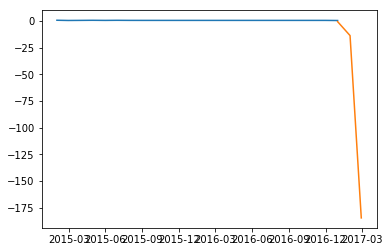

In [62]:
churn_forecast = TTS.join_time_series_dfs_on_index(fc_data, 
                                                    fc_df,
                                                   date_range_freq = 'M',
                                                    set_as_index = True)

plt.plot(churn_forecast[['churn_prob', 'point_forecast']])
plt.show()

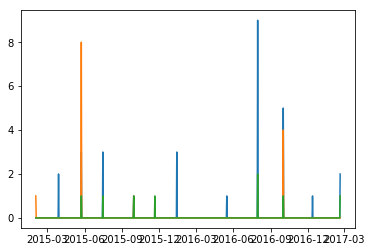

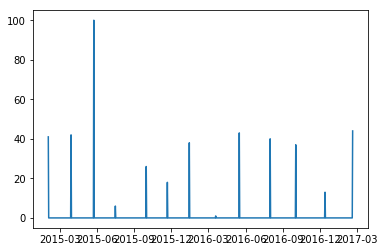

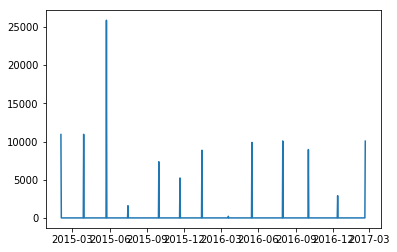

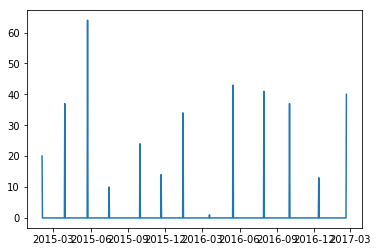

In [276]:
#These look bad but still somewhat useful for a time series model, or so I hope.
plt.plot(user_log_time_series_panel.num_25)
plt.plot(user_log_time_series_panel.num_50)
plt.plot(user_log_time_series_panel.num_75)
plt.show()
plt.plot(user_log_time_series_panel.num_100)
plt.show()
plt.plot(user_log_time_series_panel.total_secs)
plt.show()
plt.plot(user_log_time_series_panel.num_unq)
plt.show()

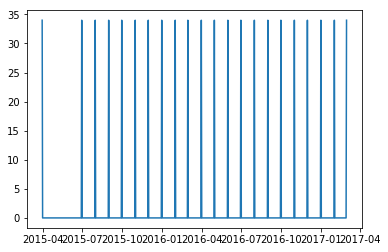

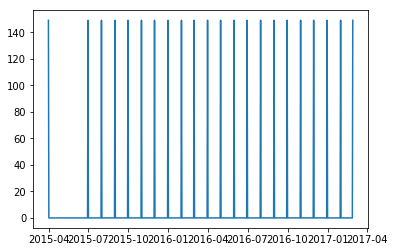

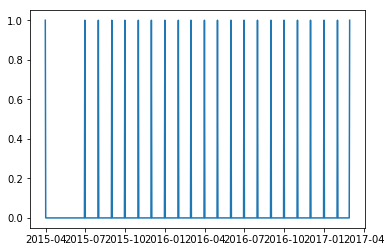

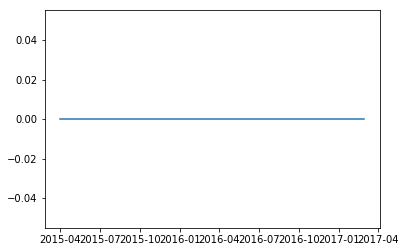

In [280]:
#These aren't the most valuable time series...
plt.plot(user_trans_time_series_panel.payment_method_id)
plt.show()
plt.plot(user_trans_time_series_panel.actual_amount_paid)
plt.show()
plt.plot(user_trans_time_series_panel.is_auto_renew)
plt.show()
plt.plot(user_trans_time_series_panel.is_cancel)
plt.show()